<a href="https://colab.research.google.com/github/vipul43/project_MASK/blob/main/basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# importing dataset from kaggle
!pip install -q kaggle &> /dev/null
from google.colab import files
files.upload()
!mkdir ~/.kaggle &> /dev/null
!cp kaggle.json ~/.kaggle/ &> /dev/null
!chmod 600 ~/.kaggle/kaggle.json &> /dev/null
!kaggle datasets list &> /dev/null
# enter dataset API command below
!kaggle datasets download -d andrewmvd/face-mask-detection &> /dev/null
!mkdir train &> /dev/null
!unzip face-mask-detection.zip -d train &> /dev/null
!rm -rf face-mask-detection.zip &> /dev/null
!rm -rf kaggle.json &> /dev/null

Saving kaggle.json to kaggle.json


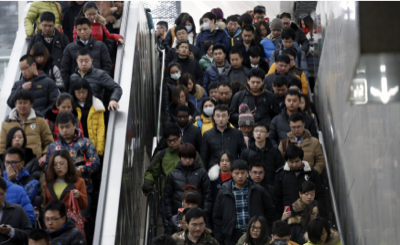

filename: maksssksksss240.png
label: without_mask
pose: Unspecified


In [42]:
# playing around with data
from IPython.display import Image, display
import random
from bs4 import BeautifulSoup
def parseXML(path):
  with open(path, 'r') as f: 
    data = f.read()
  bs_data = BeautifulSoup(data, "xml")
  filename = bs_data.find('filename').text
  label = bs_data.find('name').text
  pose = bs_data.find('pose').text
  print("filename: " + filename)
  print("label: " + label)
  print("pose: " + pose)

random_title = str(random.randint(0, 853))
display(Image("/content/train/images/maksssksksss" + random_title + ".png"))
parseXML("/content/train/annotations/maksssksksss" + random_title + ".xml")